Author: Franziska

Codebase from Bhupen

# Finetune CNN model for the 4 classes dataset

## Setup and Libaries

In [42]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers, Sequential, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from collections import defaultdict
import os
import cv2
import numpy as np
import pandas as pd
import sys
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Load truncated images
Image.LOAD_TRUNCATED_IMAGES = True

# Set the path to the data directory
data_path = "../raw_data"

# Define labels dictionary
labels_dict = {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}

## Data Exploration

### Count Image Shapes

In [2]:
def count_image_shapes(image_folder):
    """
    Count and print the number of images with each unique shape in the specified folder.

    Parameters:
    image_folder (str): The path to the folder containing the images.
    """
    shape_counts = defaultdict(int)  # Dictionary to store the count of each shape

    for image_name in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # Load image with original channels
        if image is not None:
            shape_counts[image.shape] += 1
        else:
            print(f"Failed to load image: {image_name}")

    # Print the number of images with each shape
    for shape, count in shape_counts.items():
        print(f"Shape: {shape}, Count: {count}")

In [3]:
for key in labels_dict.keys():
    print(f"\n{key.capitalize()} images:")
    image_folder = os.path.join(data_path, 'satellite_images_4_classes', key)
    count_image_shapes(image_folder)


Cloudy images:
Shape: (256, 256, 3), Count: 1500

Desert images:
Shape: (256, 256, 3), Count: 1131

Green_area images:
Shape: (64, 64, 3), Count: 1500

Water images:
Shape: (64, 64, 3), Count: 1500


## Data Preperation and Preprocessing

### Load and Preprocess Data

In [4]:
def preprocess_image(image_path, target_size):
    """
    Preprocess an image by resizing and ensuring it has 3 channels.

    Parameters:
    image_path (str): The path to the image.
    target_size (tuple): The target size for the image (width, height).

    Returns:
    np.array: The preprocessed image array.
    """
    img = Image.open(image_path)
    if img.size == (256, 256):
        img = img.resize(target_size)
    img_array = np.asarray(img, dtype='uint8')[:,:,:3]  # Ensure RGB format
    return img_array

def load_data_4_classes(data_path, reduction_factor=10):
    """
    Load and preprocess images for 4 classes, rescaling high-resolution images
    and reducing dataset size for faster processing.

    Parameters:
    data_path (str): The base path to the data directory.
    reduction_factor (int): Factor by which to reduce the dataset size.

    Returns:
    np.array: Preprocessed image data.
    np.array: Corresponding labels.
    """
    labels_dict = {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}
    target_size = (64, 64)
    X, y = [], []

    for label, class_idx in labels_dict.items():
        path_to_data = os.path.join(data_path, 'satellite_images_4_classes', label)
        images = np.array(os.listdir(path_to_data))
        selected_indices = np.random.choice(len(images), round(len(images) / reduction_factor), replace=False)
        selected_images = images[selected_indices]

        for image_name in selected_images:
            image_path = os.path.join(path_to_data, image_name)
            img_array = preprocess_image(image_path, target_size)
            X.append(img_array)
            y.append(class_idx)

    # Shuffle the dataset
    combined = list(zip(X, y))
    np.random.shuffle(combined)
    X, y = zip(*combined)

    return np.array(X), np.array(y)

In [5]:
# Load data
X, y = load_data_4_classes(data_path, reduction_factor=1)
print(f'Shape of X : {X.shape}')

Shape of X : (5631, 64, 64, 3)


### Checking for Imbalance

In [6]:
# Checking for class imbalance
for i, label in enumerate(labels_dict):
    print(f'Fraction of class {label} : {len(y[y==i]) / len(y)}')

Fraction of class cloudy : 0.2663825253063399
Fraction of class desert : 0.20085242408098028
Fraction of class green_area : 0.2663825253063399
Fraction of class water : 0.2663825253063399


### Train-Test Split

In [7]:
# Split data
split_frac = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_frac)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (4504, 64, 64, 3), Test shape: (1127, 64, 64, 3)


### Normalization and One-Hot Encoding

In [8]:
# Normalization
X_train_rescaled = X_train / 255
X_test_rescaled = X_test / 255

# One-hot encoding the labels
n_labels = len(set(y))
y_train = to_categorical(y_train, n_labels)
y_test = to_categorical(y_test, n_labels)


## Model Building

### Model Initializing

In [66]:
def initialize_model(input_shape, n_labels):
    """
    Initialize and compile a CNN model.

    Parameters:
    input_shape (tuple): The shape of the input data.
    n_labels (int): The number of output classes.

    Returns:
    Sequential: The compiled CNN model.
    """
    model = Sequential()

    model.add(layers.Conv2D(16, (4, 4), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(n_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [67]:
# Initialize the model
input_shape = (X_train_rescaled.shape[1], X_train_rescaled.shape[2], X_train_rescaled.shape[3])
model = initialize_model(input_shape, n_labels)
model.summary()

/home/franziska/.pyenv/versions/3.10.6/envs/EnviroClass/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 61, 61, 16)     │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 30, 30, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 15, 15, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │        50,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,804 (432.83 KB)

 Trainable params: 110,804 (432.83 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training and Evaluation

### Training the Model

In [68]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

# Train the model with the additional callback
history = model.fit(
    X_train_rescaled,
    y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=30,
    callbacks=[early_stopping, model_checkpoint] #, reduce_lr]
)

Epoch 1/500
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4452 - loss: 1.0650

121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.4478 - loss: 1.0603 - val_accuracy: 0.5816 - val_loss: 0.9569
Epoch 2/500
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7660 - loss: 0.5222

121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.7664 - loss: 0.5216 - val_accuracy: 0.8158 - val_loss: 0.4539
Epoch 3/500
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8148 - loss: 0.4428

121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.8145 - loss: 0.4433 - val_accuracy: 0.8324 - val_loss: 0.4019
Epoch 4/500
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8303 - loss: 0.3951

121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.8304 - loss: 0.3950 - val_accuracy: 0.8302 - val_loss: 0.3988
Epoch 5/500
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8489 - loss: 0.3728

121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.8490 - loss: 0.3726 - val_accuracy: 0.8502 - val_loss: 0.3723
Epoch 6/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.8466 - loss: 0.3775 - val_accuracy: 0.7836 - val_loss: 0.4758
Epoch 7/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.8319 - loss: 0.3923 - val_accuracy: 0.8491 - val_loss: 0.4467
Epoch 8/500
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8446 - loss: 0.3802

121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.8448 - loss: 0.3798 - val_accuracy: 0.8535 - val_loss: 0.3711
Epoch 9/500
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8459 - loss: 0.3826

121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.8459 - loss: 0.3825 - val_accuracy: 0.8713 - val_loss: 0.3126
Epoch 10/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.8733 - loss: 0.3169 - val_accuracy: 0.8657 - val_loss: 0.3409
Epoch 11/500
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8789 - loss: 0.3081

121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.8789 - loss: 0.3078 - val_accuracy: 0.8790 - val_loss: 0.3002
Epoch 12/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.8974 - loss: 0.2642 - val_accuracy: 0.8313 - val_loss: 0.4167
Epoch 13/500
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8945 - loss: 0.2754

121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.8946 - loss: 0.2752 - val_accuracy: 0.9068 - val_loss: 0.2658
Epoch 14/500
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9135 - loss: 0.2261

121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9135 - loss: 0.2261 - val_accuracy: 0.9223 - val_loss: 0.2026
Epoch 15/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.9281 - loss: 0.2003 - val_accuracy: 0.8890 - val_loss: 0.2830
Epoch 16/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.8951 - loss: 0.2558 - val_accuracy: 0.9057 - val_loss: 0.2279
Epoch 17/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.9137 - loss: 0.2228 - val_accuracy: 0.9012 - val_loss: 0.2493
Epoch 18/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.9263 - loss: 0.1958 - val_accuracy: 0.9334 - val_loss: 0.2273
Epoch 19/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.9043 - loss: 0.2553 - val_accuracy: 0.8690 - val_loss: 0.3768
Epoch 20/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.8965 - loss: 0.2712 - val_accuracy: 0.9112 - val_loss: 0.2199
Epoch 21/500
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9211 - loss: 0.2062

121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9211 - loss: 0.2059 - val_accuracy: 0.9223 - val_loss: 0.2000
Epoch 22/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9232 - loss: 0.2037 - val_accuracy: 0.9068 - val_loss: 0.2642
Epoch 23/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.9202 - loss: 0.2016 - val_accuracy: 0.8968 - val_loss: 0.2685
Epoch 24/500
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9062 - loss: 0.2447

121/121 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.9065 - loss: 0.2440 - val_accuracy: 0.9334 - val_loss: 0.1775
Epoch 25/500
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9317 - loss: 0.1663

121/121 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.9316 - loss: 0.1666 - val_accuracy: 0.9356 - val_loss: 0.1769
Epoch 26/500
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9260 - loss: 0.1827

121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9260 - loss: 0.1826 - val_accuracy: 0.9345 - val_loss: 0.1617
Epoch 27/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.9363 - loss: 0.1568 - val_accuracy: 0.9345 - val_loss: 0.1722
Epoch 28/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.9185 - loss: 0.2007 - val_accuracy: 0.8901 - val_loss: 0.2663
Epoch 29/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9357 - loss: 0.1694 - val_accuracy: 0.8835 - val_loss: 0.2653
Epoch 30/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9251 - loss: 0.1936 - val_accuracy: 0.9190 - val_loss: 0.1810
Epoch 31/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9334 - loss: 0.1738 - val_accuracy: 0.9201 - val_loss: 0.2077
Epoch 32/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.9240 - loss: 0.1774 - val_accuracy: 0.9334 - val_loss: 0.1645
Epoch 33/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.9364 - loss: 0.1579 - 

### Plot Training History

In [57]:
def plot_history(history):
    """
    Plot the training history of the model.

    Parameters:
    history (History): The history object returned by model.fit().
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='val')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy')
    ax2.plot(history.history['val_accuracy'], label='val accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()

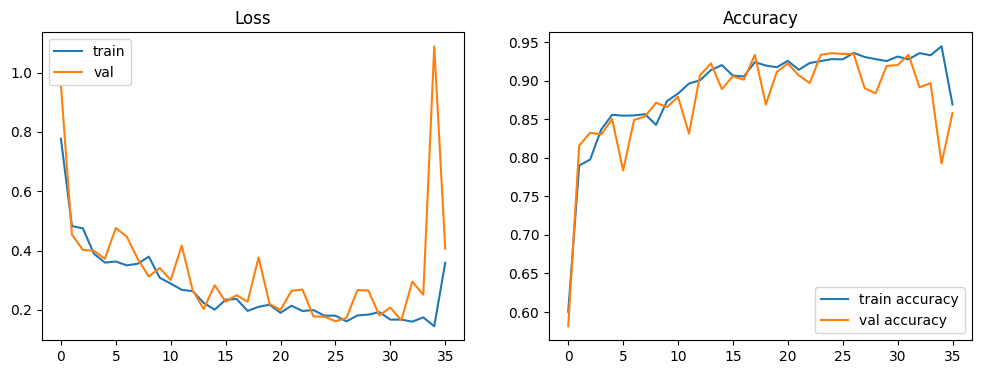

In [69]:
# Plot training history
plot_history(history)

## Model Evaluation

### Classification Report and Confusion Matrix

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Classification Report:
              precision    recall  f1-score   support

      cloudy       0.93      1.00      0.96       311
      desert       1.00      1.00      1.00       243
  green_area       0.91      0.90      0.90       304
       water       0.88      0.82      0.85       269

    accuracy                           0.93      1127
   macro avg       0.93      0.93      0.93      1127
weighted avg       0.93      0.93      0.93      1127



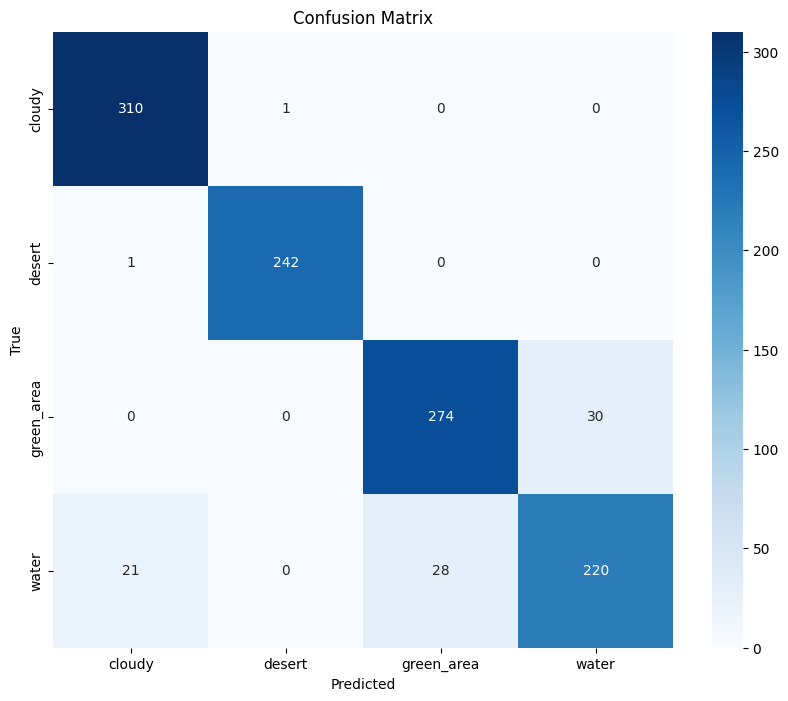

In [70]:
# Evaluate model
y_pred = model.predict(X_test_rescaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(labels_dict.keys())))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels_dict.keys()), yticklabels=list(labels_dict.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Save Model

In [71]:
# Save the final model
#model_path = f'../models/model_acc_{max(history.history["val_accuracy"]):.4f}.keras'
model.save("../model.keras")

In [72]:
# Load the model
model = load_model("../Amodel.keras")

# Evaluate the model
_, accuracy = model.evaluate(X_test_rescaled, y_test)
print(f"Test accuracy: {accuracy:.4f}")


/home/franziska/.pyenv/versions/3.10.6/envs/EnviroClass/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9328 - loss: 0.1614
Test accuracy: 0.9281
